In [1]:
# Import packages
import pandas as pd
import os
import secrets
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from stock_prediction_plotter import Plotter
from stock_prediction_lstm import LongShortTermMemory
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dropout, Dense, LSTM


TIME_STEPS = 3

pd.options.mode.chained_assignment = None

2023-04-13 16:55:21.961623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Start with a small subset of the data (5000 rows)
fields = ['timestamp', 'Asset_ID', 'Close']
train_df = pd.read_csv(f'./g-research-crypto-forecasting/train.csv', low_memory=False, 
                       dtype={'Asset_ID': 'int8', 'Count': 'int32', 'row_id': 'int32', 'Count': 'int32', 
                              'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 
                              'Volume': 'float64', 'VWAP': 'float64'
                             }
                      , nrows=5000
                      , usecols=fields)
train_df.dropna(axis = 0, inplace = True)
print(train_df.head(3))

# Print the list of Assets

    timestamp  Asset_ID      Close
0  1514764860         2   2374.590
1  1514764860         0      8.530
2  1514764860         1  13850.176


In [3]:
print(train_df['Asset_ID'].unique())

# Let's try BTC
train_btc = train_df[train_df['Asset_ID'] == 1]
del train_btc['Asset_ID']
print(train_btc.head(3))

# 70% of the data for training, the rest for validation
training_data = train_btc[:int(train_btc.shape[0]*0.7)].copy()
test_data = train_btc[int(train_btc.shape[0]*0.7):].copy()
print(training_data.head(3))
print(test_data.head(3))

training_data = training_data.set_index('timestamp')
test_data = test_data.set_index('timestamp')

min_max = MinMaxScaler(feature_range=(0, 1))
train_scaled = min_max.fit_transform(training_data)

print('mean:', train_scaled.mean(axis=0))
print('max', train_scaled.max())
print('min', train_scaled.min())
print('Std dev:', train_scaled.std(axis=0))


[ 2  0  1  5  7  6  9 11]
     timestamp      Close
2   1514764860  13850.176
10  1514764920  13828.102
18  1514764980  13801.314
     timestamp      Close
2   1514764860  13850.176
10  1514764920  13828.102
18  1514764980  13801.314
       timestamp      Close
3508  1514792160  13797.756
3516  1514792220  13799.464
3522  1514792280  13739.120
mean: [0.4404526]
max 1.0
min 0.0
Std dev: [0.21723046]


In [4]:
# Training Data Transformation
x_train = []
y_train = []
for i in range(TIME_STEPS, train_scaled.shape[0]):
    x_train.append(train_scaled[i - TIME_STEPS:i])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - TIME_STEPS:]
test_scaled = min_max.fit_transform(inputs)


In [5]:
# Testing Data Transformtion

x_test = []
y_test = []
for i in range(TIME_STEPS, test_scaled.shape[0]):
    x_test.append(test_scaled[i - TIME_STEPS:i])
    y_test.append(test_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_train)
print(y_train)

[[[0.85840947]
  [0.8232721 ]
  [0.78063099]]

 [[0.8232721 ]
  [0.78063099]
  [0.72766547]]

 [[0.78063099]
  [0.72766547]
  [0.65901754]]

 ...

 [[0.81413836]
  [0.8400242 ]
  [0.86640031]]

 [[0.8400242 ]
  [0.86640031]
  [0.85517176]]

 [[0.86640031]
  [0.85517176]
  [0.82395021]]]
[0.72766547 0.65901754 0.64659833 0.57310178 0.65334119 0.65160931
 0.65103944 0.62985897 0.60502053 0.61400783 0.61563147 0.5851135
 0.46658655 0.5009519  0.45029448 0.50174143 0.46240807 0.4701856
 0.47687116 0.45954602 0.46614562 0.51385184 0.54501608 0.55549967
 0.5501544  0.53703161 0.50213619 0.55309605 0.56969215 0.57838019
 0.54070867 0.56801757 0.56739996 0.53600013 0.51713412 0.5184394
 0.522594   0.52555156 0.5069689  0.42473019 0.51037853 0.52299831
 0.52657349 0.58868231 0.58778772 0.60822323 0.56793162 0.6045812
 0.60959218 0.57436567 0.56374837 0.56926236 0.49065614 0.4282035
 0.49124511 0.5342205  0.51541817 0.52846806 0.51537996 0.52759861
 0.5226322  0.51256566 0.44266181 0.38935246 0.

plotting Data and Histogram


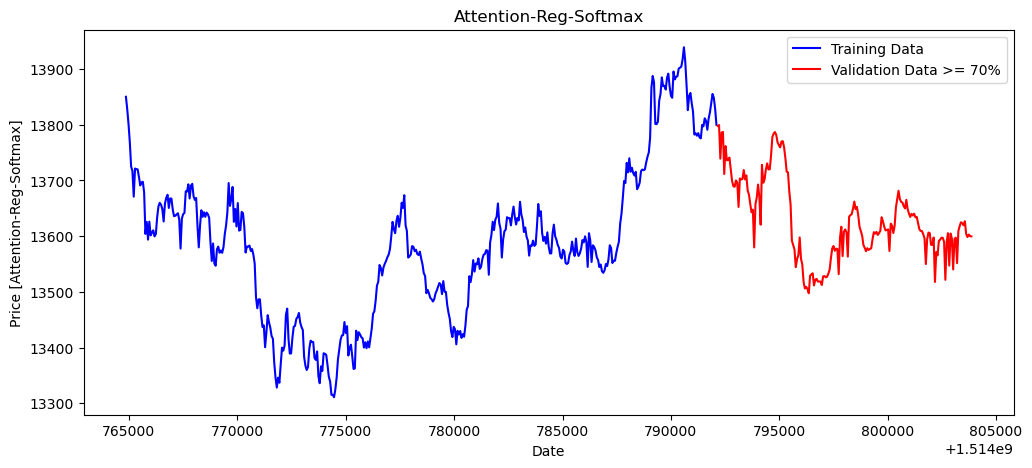

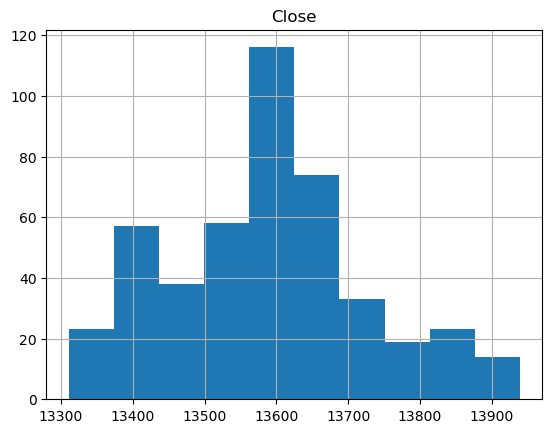

In [6]:
STOCK_TICKER = 'Attention-Reg-Softmax'
TODAY_RUN = datetime.today().strftime("%Y%m%d")
TOKEN = STOCK_TICKER + '_' + TODAY_RUN + '_' + secrets.token_hex(16)
PROJECT_FOLDER = os.path.join(os.getcwd(), TOKEN)
if not os.path.exists(PROJECT_FOLDER):
    os.makedirs(PROJECT_FOLDER)
        
plotter = Plotter(True, PROJECT_FOLDER, STOCK_TICKER, STOCK_TICKER, STOCK_TICKER)
plotter.plot_histogram_data_split(training_data, test_data, 70)

In [7]:
def get_defined_metrics():
        defined_metrics = [
            tf.keras.metrics.MeanSquaredError(name='MSE')
        ]
        return defined_metrics

def get_callback():
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
        return callback


In [10]:
from keras.layers import Dense, LSTM, Input, Lambda, concatenate
from keras.models import Model

# define input shape for time series data
input_shape = (x_train.shape[1], 1)

# define input layer
inputs = Input(shape=input_shape, name='input_layer')

# define LSTM layer
lstm_layer = LSTM(units=100, return_sequences=True)(inputs)

# define attention layer
attention_probs = Dense(1, activation='softmax', name='attention_probs')(lstm_layer)
attention_probs = Lambda(lambda x: x, name='attention_probs2')(attention_probs)
attention_mul = concatenate([lstm_layer, attention_probs], name='attention_mul')

# define additional LSTM layers
lstm_layer = LSTM(units=50, return_sequences=True)(attention_mul)
lstm_layer = Dropout(0.2)(lstm_layer)

lstm_layer = LSTM(units=50, return_sequences=True)(lstm_layer)
lstm_layer = Dropout(0.2)(lstm_layer)

lstm_layer = LSTM(units=50)(lstm_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

# define output layer
output = Dense(units=1, name='output_layer')(lstm_layer)

# define model
model = Model(inputs=inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=get_defined_metrics())

# train model
history = model.fit(x_train, y_train, 
          batch_size=32, 
          epochs=100,
          callbacks=[get_callback()],
          validation_data=(x_test, y_test))


2023-04-07 13:41:55.878660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
15/15 [==============================] - 6s 82ms/step - loss: 0.1523 - MSE: 0.1523 - val_loss: 0.0351 - val_MSE: 0.0351
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0417 - MSE: 0.0417 - val_loss: 0.0324 - val_MSE: 0.0324
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0336 - MSE: 0.0336 - val_loss: 0.0303 - val_MSE: 0.0303
Epoch 4/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0178 - MSE: 0.0178 - val_loss: 0.0143 - val_MSE: 0.0143
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0059 - MSE: 0.0059 - val_loss: 0.0081 - val_MSE: 0.0081
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0072 - val_MSE: 0.0072
Epoch 7/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0039 - MSE: 0.0039 - val_loss: 0.0075 - val_MSE: 0.0075
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0

plotting loss


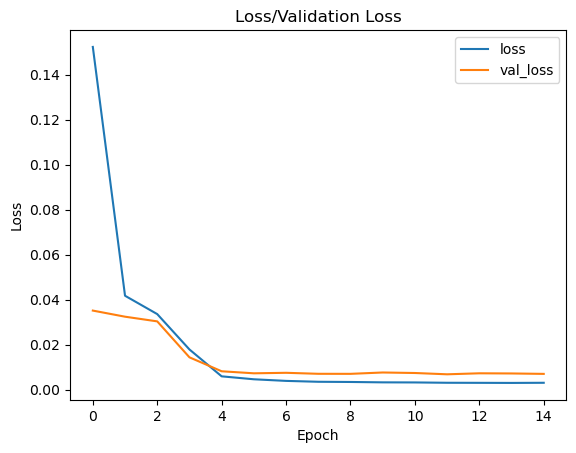

plotting MSE


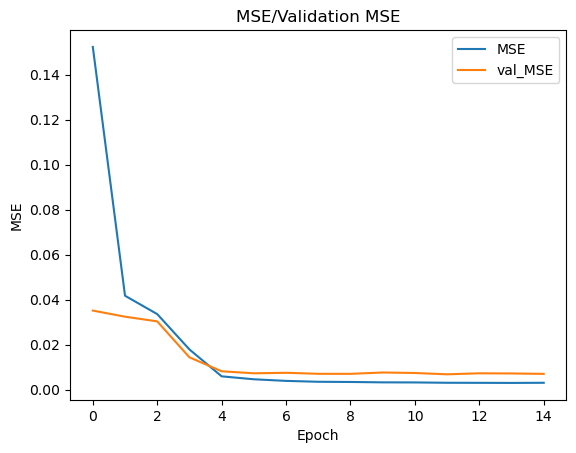

In [11]:
model.save(os.path.join(PROJECT_FOLDER, 'model_weights.h5'))
plotter.plot_loss(history)
plotter.plot_mse(history)

In [12]:
model_overfitt = Sequential()
# 1st layer with Dropout regularisation
# * units = add 100 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
# * input_shape => Shape of the training dataset
model_overfitt.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# 20% of the layers will be dropped
model_overfitt.add(Dropout(0.2))
# 2nd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model_overfitt.add(LSTM(units=50, return_sequences=True))
# 20% of the layers will be dropped
model_overfitt.add(Dropout(0.2))
# 3rd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model_overfitt.add(LSTM(units=50, return_sequences=True))
# 50% of the layers will be dropped
model_overfitt.add(Dropout(0.5))
# 4th LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
model_overfitt.add(LSTM(units=50))
# 50% of the layers will be dropped
model_overfitt.add(Dropout(0.5))
# Dense layer that specifies an output of one unit
model_overfitt.add(Dense(units=1))
# model_overfitt.summary()

# Add regularization
from tensorflow.keras import regularizers

model_overfitt = Sequential()
model_overfitt.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1),
               kernel_regularizer=regularizers.l2(0.01)))
model_overfitt.add(Dropout(0.2))
model_overfitt.add(LSTM(units=50, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model_overfitt.add(Dropout(0.2))
model_overfitt.add(LSTM(units=50, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model_overfitt.add(Dropout(0.5))
model_overfitt.add(LSTM(units=50, kernel_regularizer=regularizers.l2(0.01)))
model_overfitt.add(Dropout(0.5))
model_overfitt.add(Dense(units=1))
# model_overfitt.summary()

# Add early stopping
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model_overfitt.compile(optimizer='adam', loss='mean_squared_error',metrics=get_defined_metrics())
history_overfitt = model_overfitt.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test),
                    callbacks=[get_callback()])


Epoch 1/100
15/15 [==============================] - 6s 81ms/step - loss: 0.1701 - MSE: 0.2001 - val_loss: 0.0438 - val_MSE: 0.1475
Epoch 2/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0414 - MSE: 0.1081 - val_loss: 0.0296 - val_MSE: 0.0884
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0364 - MSE: 0.0771 - val_loss: 0.0242 - val_MSE: 0.0693
Epoch 4/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0236 - MSE: 0.0627 - val_loss: 0.0139 - val_MSE: 0.0571
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0172 - MSE: 0.0525 - val_loss: 0.0077 - val_MSE: 0.0484
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0117 - MSE: 0.0450 - val_loss: 0.0083 - val_MSE: 0.0420
Epoch 7/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0128 - MSE: 0.0396 - val_loss: 0.0071 - val_MSE: 0.0375
Epoch 8/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0103

plotting loss


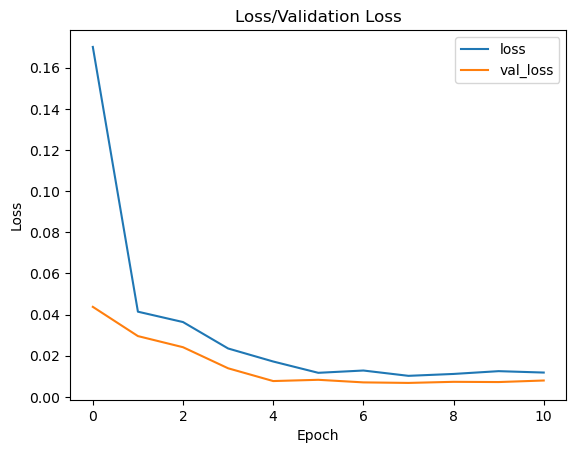

plotting MSE


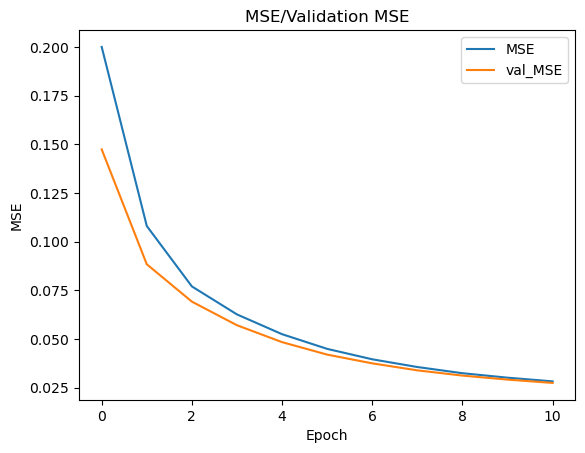

In [13]:
model.save(os.path.join(PROJECT_FOLDER, 'model_weights.h5'))
plotter.plot_loss(history_overfitt)
plotter.plot_mse(history_overfitt)

## Most plausible Attention Mechanism Model

In [8]:
from keras.layers import Dense, LSTM, Dropout, Input, Concatenate, dot, Activation, Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam

# define the input layer
inputs = Input(shape=(x_train.shape[1], 1))

# add the LSTM layers with regularization
lstm_out = LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.001))(inputs)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.001))(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.001))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)
lstm_out = LSTM(units=50, kernel_regularizer=l2(0.001))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)

# add the attention mechanism
attn_out = Dense(50, activation='softmax')(lstm_out)
attn_out = Activation('softmax')(attn_out)
context = dot([attn_out, lstm_out], axes=1)
context = Flatten()(context)
context = Dense(64, activation='relu')(context)

# concatenate the LSTM and attention layers
merged = Concatenate()([lstm_out, context])

# add the output layer with regularization
output = Dense(units=1, kernel_regularizer=l2(0.001))(merged)

# create the model
model_att_reg = Model(inputs=inputs, outputs=output)

# compile the model with a lower learning rate and using Mean Squared Error as the loss function
adam = Adam(lr=0.0001)
model_att_reg.compile(optimizer=adam, loss='mse', metrics=get_defined_metrics())

history_att_reg = model_att_reg.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test),
                    callbacks=[get_callback()])

2023-04-13 16:55:44.683579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100


/Users/devangdayal/opt/anaconda3/envs/Workspace/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


15/15 [==============================] - 5s 78ms/step - loss: 0.5246 - MSE: 0.2320 - val_loss: 0.4566 - val_MSE: 0.1688
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 0.5032 - MSE: 0.2191 - val_loss: 0.4372 - val_MSE: 0.1578
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 0.4813 - MSE: 0.2054 - val_loss: 0.4178 - val_MSE: 0.1463
Epoch 4/100
15/15 [==============================] - 0s 10ms/step - loss: 0.4596 - MSE: 0.1914 - val_loss: 0.3982 - val_MSE: 0.1343
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.4374 - MSE: 0.1766 - val_loss: 0.3783 - val_MSE: 0.1216
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.4146 - MSE: 0.1609 - val_loss: 0.3577 - val_MSE: 0.1078
Epoch 7/100
15/15 [==============================] - 0s 10ms/step - loss: 0.3898 - MSE: 0.1427 - val_loss: 0.3366 - val_MSE: 0.0930
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: 0.3640 - MSE: 

plotting loss


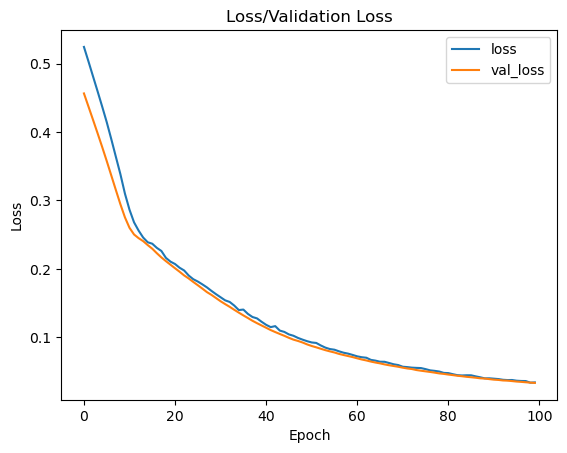

plotting MSE


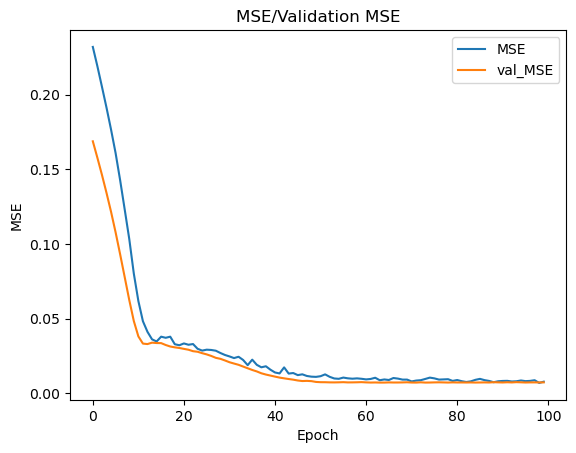

In [9]:
model_att_reg.save(os.path.join(PROJECT_FOLDER, 'model_weights.h5'))
plotter.plot_loss(history_att_reg)
plotter.plot_mse(history_att_reg)

In [10]:
model_att_reg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 3, 100)       40800       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 3, 100)       0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 3, 50)        30200       ['dropout[0][0]']                
                                                                                              

In [13]:
from keras.utils.vis_utils import plot_model
# plot_model(model_att_reg, to_file='model_att_reg.png')
#plot_model(model_overfitt, to_file='model_overfitting.png')


model_att_reg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 3, 100)       40800       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 3, 100)       0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 3, 50)        30200       ['dropout[0][0]']                
                                                                                              

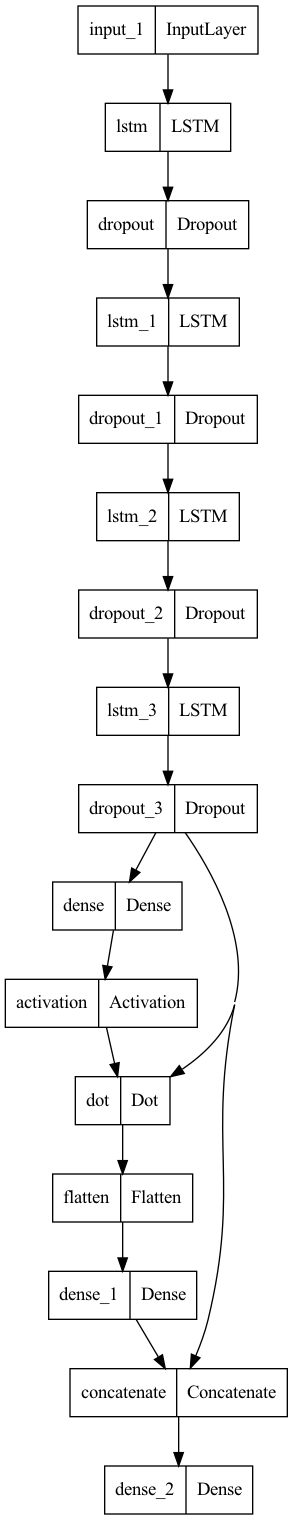

In [14]:
plot_model(model_att_reg,to_file='model_att_noreg.png')

In [26]:
loss = model_att_reg.evaluate(x_train,y_train)

15/15 [==============================] - 0s 9ms/step - loss: 0.0295 - MSE: 0.0037


plotting loss


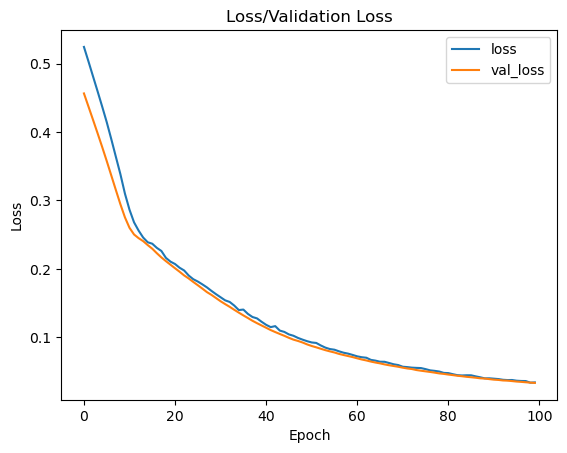

plotting MSE


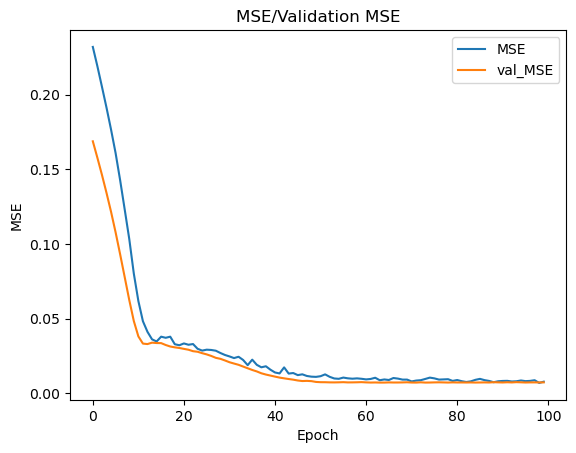

In [27]:
plotter.plot_loss(history_att_reg)
plotter.plot_mse(history_att_reg)